In [236]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [237]:
def cost_function(x_vec):
    return np.linalg.norm(x_vec)

def cost_function_grad(x_vec):
    return x_vec / np.linalg.norm(x_vec)

def cost_function_hessian(x_vec):
    return np.eye(len(x_vec)) / np.linalg.norm(x_vec) - np.outer(x_vec, x_vec) / np.linalg.norm(x_vec)**3

In [238]:
def test_function(alpha, x_vec):
    return cost_function(alpha * x_vec)

def test_function_grad(alpha, x_vec):
    return cost_function_grad(alpha * x_vec).flatten() @ x_vec.flatten()

def test_function_hessian(alpha, x_vec):
    return x_vec.flatten() @ cost_function_hessian(alpha * x_vec) @ x_vec.flatten()

def test_function_approx(alpha, x_vec, point=0):
    return test_function(point, x_vec) + (alpha - point) * test_function_grad(point, x_vec) + (alpha - point)**2 / 2 * test_function_hessian(point, x_vec)

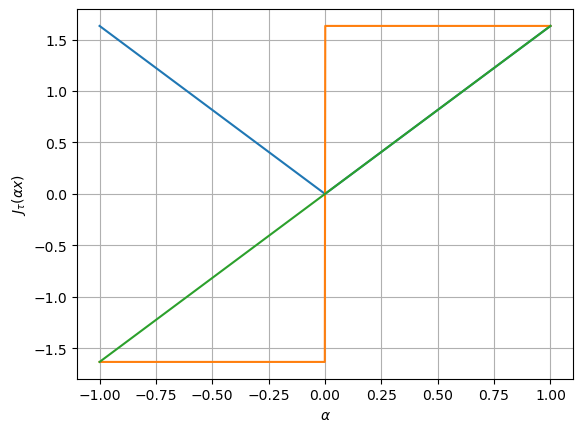

In [239]:
std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

alpha_bounds = np.linspace(-1e0, 1e0, 1000)
cost_values = [test_function(alpha, sample_x_vec) for alpha in alpha_bounds]
gradient_values = [test_function_grad(alpha, sample_x_vec) for alpha in alpha_bounds]
taylor_series_second_order_expansion_cost_function = [test_function_approx(alpha, sample_x_vec, point=1e-6) for alpha in alpha_bounds]

plt.plot(alpha_bounds, cost_values)
plt.plot(alpha_bounds, gradient_values)
plt.plot(alpha_bounds, taylor_series_second_order_expansion_cost_function)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$J_\tau(\alpha x)$')
plt.grid()
plt.show()

In [240]:
# mu = 3.986e14
mu = 1.0

# Analytical
def function(p_vec):
    p_norm = np.linalg.norm(p_vec)
    return -mu * p_vec / p_norm**3

def first_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (np.eye(n) / p_norm**3 - 3 * np.outer(p_vec, p_vec) / p_norm**5)

def second_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (-3 / p_norm**5 * (np.outer(np.eye(n), p_vec) + np.kron(np.eye(n), p_vec) + np.kron(p_vec, np.eye(n))) + 15 / p_norm**7 * np.kron(p_vec, np.outer(p_vec, p_vec))) 

def differential_equation(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    return np.concatenate((v_vec, function(p_vec)))

def first_order_partial_derivatives_for_the_differential_equation(x_vec):
    first_order_pder = np.zeros((6, 6))
    p_vec = x_vec[:3]
    first_order_pder[:3, 3:] = np.eye(3)
    first_order_pder[3:, :3] = first_order_partial_derivatives(p_vec)
    return first_order_pder

def second_order_partial_derivatives_for_the_differential_equation(x_vec):
    second_order_pder = np.zeros((6 * 6, 6))
    p_vec = x_vec[:3]
    aux = second_order_partial_derivatives(p_vec)
    for i in range(3):
        second_order_pder[6*i+3:6*i+6, :3] = aux[i*3:i*3+3, :]
    return second_order_pder

def f(dt, x_old):
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)
    k4 = differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = second_order_partial_derivatives_for_the_differential_equation(x_old)
    Hk2 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(np.eye(6), first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1)) @ (dt / 2 * Hk1)
    Hk3 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(np.eye(6), first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2)) @ (dt / 2 * Hk2)
    Hk4 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(np.eye(6), first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

In [241]:
def h(x_vec):
    return x_vec[:3]
    
def H(y, x_vec):
    o = len(y)
    n = len(x_vec)
    aux = np.zeros((o, n))
    aux[:, :3] = np.eye(o)  
    return aux

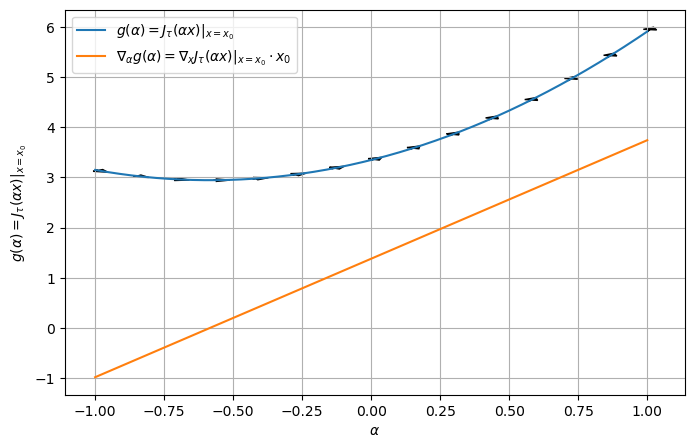

In [247]:
R = np.diag([1e0, 1e0, 1e0])

def cost_function(y, x_vec): # For the initial conditions, for now
    return (1 / 2 * (y - h(x_vec)).T @ np.linalg.inv(R) @ (y - h(x_vec)))

def cost_function_grad(y, x_vec):
    return -H(y, x_vec).T @ np.linalg.inv(R) @ (y - h(x_vec))

def test_function(y, alpha, x_vec):
    return cost_function(y, alpha * x_vec).flatten()

def test_function_grad(y, alpha, x_vec):
    return cost_function_grad(y, alpha * x_vec).flatten() @ x_vec.flatten()

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

dt = 60.0
y = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

alpha_bounds = np.linspace(-1e0, 1e0, 1000)
cost_values = np.array([test_function(y, alpha, sample_x_vec) for alpha in alpha_bounds]).flatten()
gradient_values = np.array([test_function_grad(y, alpha, sample_x_vec) for alpha in alpha_bounds])

# Plot function and gradient
plt.figure(figsize=(8, 5))
plt.plot(alpha_bounds, cost_values, label=r'$g(\alpha) = J_\tau(\alpha x)|_{x = x_0}$')
plt.plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha) = \nabla_x J_\tau(\alpha x)|_{x = x_0} \cdot x_0$')

# Add arrows indicating derivative direction
num_arrows = 15  # Number of arrows
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

for i in arrow_indices:
    alpha = alpha_bounds[i]
    J_alpha = cost_values[i]
    grad_alpha = float(gradient_values[i])  # Ensure it's a scalar

    # Define arrow direction
    arrow_dx = np.max(alpha_bounds) * 1e-2
    arrow_dy = grad_alpha * arrow_dx  # Scale dy based on gradient

    plt.arrow(alpha, J_alpha, arrow_dx, arrow_dy, head_width=0.05, head_length=0.05, fc='black', ec='black')

# Labels and grid
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$g(\alpha) = J_\tau(\alpha x)|_{x = x_0}$')
plt.grid()
plt.legend()
plt.show()